In [1]:
import numpy as np 
import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import time
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Autoencoder

## Model specification

In [2]:
class AE(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 512),
            torch.nn.SELU(),
            torch.nn.Linear(512, 128),
            torch.nn.SELU(),
            torch.nn.Linear(128, 32)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 128),
            torch.nn.SELU(),
            torch.nn.Linear(128, 512),
            torch.nn.SELU(),
            torch.nn.Linear(512, input_size)
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Data Preparation

In [3]:
class AEDatasetTrain(Dataset):
    def __init__(self):
        self.transactions = torch.from_numpy(
            pd.read_csv('train_data.csv').drop(
                ['Month',
                'Day',
                'is_weekend',
                'hours_since_previous'],
                axis=1).to_numpy(dtype=np.float32)
            )

    def __getitem__(self, index):
        return self.transactions[index], self.transactions[index]

    def __len__(self):
        return len(self.transactions)
      

In [4]:
class AEDatasetTest(Dataset):
    def __init__(self):
        self.transactions = torch.from_numpy(
            pd.read_csv('test_data.csv').drop(
                ['Month',
                'Day',
                'is_weekend',
                'hours_since_previous'],
                axis=1).to_numpy(dtype=np.float32)
            )

    def __getitem__(self, index):
        return self.transactions[index], self.transactions[index]

    def __len__(self):
        return len(self.transactions)
      

In [5]:
BATCH_SIZE = 128
train_dataset = AEDatasetTrain()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
test_dataset = AEDatasetTest()
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Model training

In [7]:
device = 'cuda'
model = AE(input_size=779)

In [8]:
opt = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = torch.nn.MSELoss()

In [9]:
model.to(device)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=779, out_features=512, bias=True)
    (1): SELU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): SELU()
    (4): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SELU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): SELU()
    (4): Linear(in_features=512, out_features=779, bias=True)
  )
)

In [ ]:
num_epochs = 100

history = defaultdict(list)

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    train_losses = []
    pbar = tqdm(train_dataloader)
    for x_batch, y_batch in pbar:

        # calculate model predictions, calculate loss, make optimizer step
        y_pred = model(x_batch.to(device)).cpu()
        loss = criterion(y_pred[:,:11], y_batch[:,:11]) + criterion(y_pred[:,11:], y_batch[:,11:])
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_losses.append(loss.item())
        pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses):.5f}"

    model.eval()
    val_losses = []
    pbar = tqdm(test_dataloader)
    for x_batch, y_batch in pbar:

        # get model predictions, measure loss, collect data for accuracy calc
        y_pred = model(x_batch.to(device)).cpu()
        loss = criterion(y_pred[:,:11], y_batch[:,:11]) + criterion(y_pred[:,11:], y_batch[:,11:])

        val_losses.append(loss.item())
        pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  epoch_time={time.time() - start_time:.1f}s")

    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), f"AE_weights/epoch_{epoch}")

# SEQNBT

## Model specification

In [31]:
class SEQNBT(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
         
        self.recurrent = torch.nn.GRU(input_size=input_size, hidden_size=64, dropout=0.25, num_layers=3, batch_first=True)
        self.activation_1 = torch.nn.SELU()
        self.fc = torch.nn.Linear(64, 32)
        self.activation_2 = torch.nn.SELU()
 
    def forward(self, x):
        recur, _ = self.recurrent(x)
        non_lin = self.activation_1(recur[:,-1,: ])
        linear = self.fc(non_lin)
        result = self.activation_2(linear)
        return result

## Data Preparation

In [5]:
model = AE(input_size=779)
model.load_state_dict(torch.load("AE_weights/epoch_100"))
model.eval()
model.requires_grad_ = False

In [6]:
train_data = pd.read_csv('train_data.csv')
train_data.sort_values(['user_id','cumulative_transaction_count'], inplace=True)

In [7]:
train_trans_features_ = train_data.drop(['Month','Day','is_weekend','hours_since_previous'],axis=1)
train_time_features = train_data[['Month','Day','is_weekend','hours_since_previous']]

In [40]:
L = 3
sequenced_encoded_train_data = []
with torch.no_grad():
    for u in train_data.user_id.unique():
        x_trans = train_trans_features_[train_trans_features_.user_id==u].to_numpy(dtype=np.float32)
        x_temp = train_time_features[train_trans_features_.user_id==u].to_numpy(dtype=np.float32)
        x_trans_encoded = model.encoder(torch.from_numpy(x_trans)).numpy()
        x_trans_temp = np.concatenate((x_trans_encoded, x_temp),axis=1)
        for i in range(len(x_trans_encoded)-L):
            sequenced_encoded_train_data.append(x_trans_temp[i:i+L+1])

sequenced_encoded_train_data = np.array(sequenced_encoded_train_data)
np.save(f"seq_data/train_L={L}", sequenced_encoded_train_data, allow_pickle=False, fix_imports=False)


In [48]:
test_data = pd.read_csv('test_data.csv')
test_data.sort_values(['user_id','cumulative_transaction_count'], inplace=True)
test_trans_features_ = test_data.drop(['Month','Day','is_weekend','hours_since_previous'],axis=1)
test_time_features = test_data[['Month','Day','is_weekend','hours_since_previous']]

In [53]:
L = 5
sequenced_encoded_test_data = []
with torch.no_grad():
    for u in test_data.user_id.unique():
        x_trans = test_trans_features_[test_trans_features_.user_id==u].to_numpy(dtype=np.float32)
        x_temp = test_time_features[test_trans_features_.user_id==u].to_numpy(dtype=np.float32)
        x_trans_encoded = model.encoder(torch.from_numpy(x_trans)).numpy()
        x_trans_temp = np.concatenate((x_trans_encoded, x_temp),axis=1)
        for i in range(len(x_trans_encoded)-L):
            sequenced_encoded_test_data.append(x_trans_temp[i:i+L+1])

sequenced_encoded_test_data = np.array(sequenced_encoded_test_data)
np.save(f"seq_data/test_L={L}", sequenced_encoded_test_data, allow_pickle=False, fix_imports=False)

## Data Loading

In [3]:
class SeqDataset(Dataset):
    def __init__(self, part, seq_len):
        self.sessions = torch.from_numpy(np.load(f"seq_data/{part}_L={seq_len}.npy"))

    def __getitem__(self, index):
        return self.sessions[index,:-1,:], self.sessions[index,-1,:]

    def __len__(self):
        return len(self.sessions)

In [62]:
BATCH_SIZE = 128
seq_len=3
train_dataset = SeqDataset(part="train",seq_len=seq_len)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = SeqDataset(part="test",seq_len=seq_len)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Model training

In [63]:
device = 'cuda'
seq_model = SEQNBT(input_size=36)

In [64]:
opt = torch.optim.Adam(seq_model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

In [65]:
seq_model.to(device)

SEQNBT(
  (recurrent): GRU(36, 64, num_layers=3, batch_first=True, dropout=0.25)
  (activation_1): SELU()
  (fc): Linear(in_features=64, out_features=32, bias=True)
  (activation_2): SELU()
)

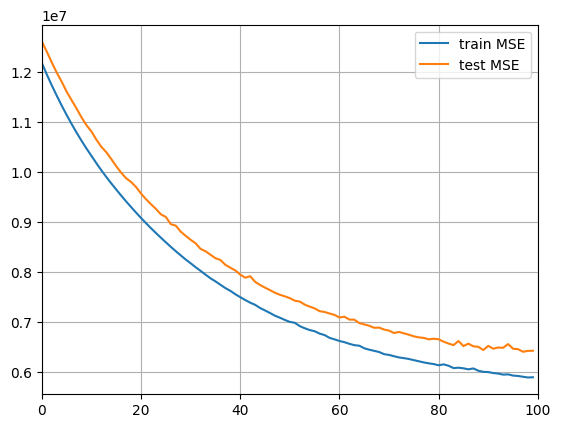

In [66]:
num_epochs = 100

history = defaultdict(list)

for epoch in range(num_epochs):
    start_time = time.time()

    seq_model.train()
    train_losses = []
    pbar = tqdm(train_dataloader)
    for x_batch, y_batch in pbar:

        # calculate model predictions, calculate loss, make optimizer step
        y_pred = seq_model(x_batch.to(device)).cpu()
        loss = criterion(y_pred, y_batch[:,:-4])
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_losses.append(loss.item())
        pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses):.5f}"

    seq_model.eval()
    val_losses = []
    pbar = tqdm(test_dataloader)
    for x_batch, y_batch in pbar:

        # get model predictions, measure loss, collect data for accuracy calc
        y_pred = seq_model(x_batch.to(device)).cpu()
        loss = criterion(y_pred, y_batch[:,:-4])

        val_losses.append(loss.item())
        pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  epoch_time={time.time() - start_time:.1f}s")

    if (epoch+1) % 10 == 0:
        torch.save(seq_model.state_dict(), f"SEQNBT_weights/L={seq_len}/epoch_{epoch+1}")
    
    clear_output()
    plt.plot(history['train_loss'],label='train MSE')
    plt.plot(history['val_loss'],label='test MSE')
    plt.legend(loc='best')
    plt.xlim(0,num_epochs)
    plt.grid()
    plt.savefig(f"figures/SEQNBT_L={seq_len}_curves.jpg")
    plt.show()


# Model evaluation

In [58]:
from sklearn.metrics.pairwise import cosine_similarity

In [60]:
full_data = pd.read_csv('full_data.csv').to_numpy()

In [61]:
sic_embeddings = np.unique(full_data[:,15:], axis=0)

In [62]:
del full_data

In [4]:
model = AE(input_size=779)
model.load_state_dict(torch.load("AE_weights/epoch_100"))
model.eval()
model.requires_grad_ = False

In [5]:
test_data = pd.read_csv('test_data.csv')
test_data.sort_values(['user_id','cumulative_transaction_count'], inplace=True)
test_trans_features_ = test_data.drop(['Month','Day','is_weekend','hours_since_previous'],axis=1)
test_time_features = test_data[['Month','Day','is_weekend','hours_since_previous']]

In [13]:
correct_embeddings = {3:[],4:[],5:[]}
correct_price = {3:[],4:[],5:[]}
for seq_len in [3,4,5]:
    for u in test_data.user_id.unique():
        x_trans = test_trans_features_[test_trans_features_.user_id==u].to_numpy(dtype=np.float32)
        for i in range(len(x_trans)-seq_len):
            correct_embeddings[seq_len].append(x_trans[i+seq_len][11:])
            correct_price[seq_len].append(x_trans[i+seq_len][1])

In [29]:
test_data_3 = torch.from_numpy(np.load(f"seq_data/test_L=3.npy"))[:,:-1,:]
test_data_4 = torch.from_numpy(np.load(f"seq_data/test_L=4.npy"))[:,:-1,:]
test_data_5 = torch.from_numpy(np.load(f"seq_data/test_L=5.npy"))[:,:-1,:]

In [32]:
device = 'cuda'
seq_model_3 = SEQNBT(input_size=36)
seq_model_3.load_state_dict(torch.load("SEQNBT_weights/L=3/epoch_100"))
seq_model_3.eval()
seq_model_3.requires_grad_ = False
seq_model_4 = SEQNBT(input_size=36)
seq_model_4.load_state_dict(torch.load("SEQNBT_weights/L=4/epoch_100"))
seq_model_4.eval()
seq_model_4.requires_grad_ = False
seq_model_5 = SEQNBT(input_size=36)
seq_model_5.load_state_dict(torch.load("SEQNBT_weights/L=5/epoch_100"))
seq_model_5.eval()
seq_model_5.requires_grad_ = False

In [41]:
with torch.no_grad():
    seq_model_3.to(device)
    y3_pred = seq_model_3(test_data_3.to(device)).cpu()
    seq_model_4.to(device)
    y4_pred = seq_model_4(test_data_4.to(device)).cpu()
    seq_model_5.to(device)
    y5_pred = seq_model_5(test_data_5.to(device)).cpu()

In [47]:

with torch.no_grad():
    model.to(device)
    y3_decoded = model.decoder(y3_pred.to(device)).cpu()
    y4_decoded = model.decoder(y4_pred.to(device)).cpu()
    y5_decoded = model.decoder(y5_pred.to(device)).cpu()

In [56]:
np.array(correct_embeddings[3]).shape

(16930, 768)

In [72]:
L3_recs = np.argsort(cosine_similarity(y3_decoded[:,11:], sic_embeddings))[:,-5:]

In [93]:
L4_recs = np.argsort(cosine_similarity(y4_decoded[:,11:], sic_embeddings))[:,-5:]

In [94]:
L5_recs = np.argsort(cosine_similarity(y5_decoded[:,11:], sic_embeddings))[:,-5:]

In [83]:
correct_recs = {3:[],4:[],5:[]}
for i in range(len(correct_embeddings[3])):
    correct_recs[3].append(np.argmin(np.linalg.norm(correct_embeddings[3][i]-sic_embeddings, axis=1)))

In [86]:
for i in range(len(correct_embeddings[4])):
    correct_recs[4].append(np.argmin(np.linalg.norm(correct_embeddings[4][i]-sic_embeddings, axis=1)))

In [87]:
for i in range(len(correct_embeddings[5])):
    correct_recs[5].append(np.argmin(np.linalg.norm(correct_embeddings[5][i]-sic_embeddings, axis=1)))

In [107]:
print("L=3 Recall@1",np.isin(correct_recs[3], L3_recs[:,-1]).mean())
print("L=3 Recall@5",np.isin(correct_recs[3], L3_recs).mean())

L=3 Recall@1 0.000531600708800945
L=3 Recall@5 0.007737743650324867


In [105]:
print("L=4 Recall@1",np.isin(correct_recs[4], L4_recs[:,-1]).mean())
print("L=4 Recall@5",np.isin(correct_recs[4], L4_recs).mean())

L=4 Recall@1 0.0009385558753597798
L=4 Recall@5 0.007383306219496934


In [106]:
print("L=5 Recall@1",np.isin(correct_recs[5], L5_recs[:,-1]).mean())
print("L=5 Recall@5",np.isin(correct_recs[5], L5_recs).mean())

L=5 Recall@1 0.0007316748702940003
L=5 Recall@5 0.007050685113742184


In [124]:
print("L=3 MAP@1", (np.divide(1,
                 np.argmax(np.array(correct_recs[3]).reshape(-1,1) == np.array(L3_recs[:,-1]),axis=1),
                 where=np.argmax(np.array(correct_recs[3]).reshape(-1,1) == np.array(L3_recs)[:,-1],axis=1)!=0)).mean())
print("L=3 MAP@5", (np.divide(1,
                 np.argmax(np.array(correct_recs[3]).reshape(-1,1) == np.array(L3_recs),axis=1),
                 where=np.argmax(np.array(correct_recs[3]).reshape(-1,1) == np.array(L3_recs),axis=1)!=0)).mean())

L=3 MAP@1 2.6993942559289693e-05
L=3 MAP@5 0.000615278598149242


In [126]:
print("L=4 MAP@1", (np.divide(1,
                 np.argmax(np.array(correct_recs[4]).reshape(-1,1) == np.array(L4_recs[:,-1]),axis=1),
                 where=np.argmax(np.array(correct_recs[4]).reshape(-1,1) == np.array(L4_recs)[:,-1],axis=1)!=0)).mean())
print("L=4 MAP@5", (np.divide(1,
                 np.argmax(np.array(correct_recs[4]).reshape(-1,1) == np.array(L4_recs),axis=1),
                 where=np.argmax(np.array(correct_recs[4]).reshape(-1,1) == np.array(L4_recs),axis=1)!=0)).mean())

L=4 MAP@1 4.38273557067092e-06
L=4 MAP@5 0.0006361323155216284


In [127]:
print("L=5 MAP@1", (np.divide(1,
                 np.argmax(np.array(correct_recs[5]).reshape(-1,1) == np.array(L5_recs[:,-1]),axis=1),
                 where=np.argmax(np.array(correct_recs[5]).reshape(-1,1) == np.array(L5_recs)[:,-1],axis=1)!=0)).mean())
print("L=3 MAP@5", (np.divide(1,
                 np.argmax(np.array(correct_recs[5]).reshape(-1,1) == np.array(L5_recs),axis=1),
                 where=np.argmax(np.array(correct_recs[5]).reshape(-1,1) == np.array(L5_recs),axis=1)!=0)).mean())

L=5 MAP@1 1.592277698629853e-06
L=3 MAP@5 0.0007649328189437276


In [128]:
y3_price = y3_pred[:,1]
y4_price = y4_pred[:,1]
y5_price = y5_pred[:,1]

In [136]:
print("L=3 MAE",(np.array(correct_price[3]) - np.array(y3_price)).mean())
print("L=4 MAE",(np.array(correct_price[4]) - np.array(y4_price)).mean())
print("L=5 MAE",(np.array(correct_price[5]) - np.array(y5_price)).mean())

L=3 MAE 227.12056
L=4 MAE 224.78374
L=5 MAE 222.98004
